In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
# from sqlalchemy import create_engine
# from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Connect to db
dbname = 'beforeiagree_db'
username = 'peterostendorp'

#Create engine
con = psycopg2.connect(database = dbname, user = username)

## Investigating site metadata

In [20]:
sql = """
SELECT * FROM sites;
"""
sites = pd.read_sql_query(sql,con)

In [21]:
sites.head()

,Policy UID,Site UID,Site URL,Site Human-Readable Name,Site Check Date,In 115 Set?,Comments,Sector,Policy URL,Policy collection date,Policy last updated date,policy_text
0,20,1,theatlantic.com,The Atlantic,2016-02-08,True,"Alexa Rank: 975 (Global), 289 (US)",Arts,theatlantic.com/privacy-policy/,2015-07-02,2015-01-01,"Privacy Policy\nEffective: January 1, 2015 ..."
1,21,2,imdb.com,IMDb,2016-02-08,True,"Alexa Rank: 49 (Global), 27 (US)",Arts,imdb.com/privacy,2015-07-02,2014-12-05,"IMDb Privacy Notice\n\nLast Updated, December ..."
2,26,3,nytimes.com,New York Times,2016-02-08,True,"Alexa Rank: 101 (Global), 22 (US)",Arts,nytimes.com/privacy,2015-07-08,2015-06-10,"Privacy Policy\nLast Updated on June 10, 2015\..."
3,32,4,theverge.com,The Verge,2016-02-08,True,"Alexa Rank: 525 (Global), 230 (US)",Home,voxmedia.com/privacy-policy,2015-07-02,2014-05-01,Your privacy is important to us and we have pr...
4,32,1000,voxmedia.com,Vox Media,2015-02-14,False,"Alexa Rank: 40248 (Global), 18551 (US)",None,voxmedia.com/privacy-policy,2015-07-02,2014-05-01,Your privacy is important to us and we have pr...


In [24]:
sites.groupby('In 115 Set?').describe().xs('Policy UID',axis=1,level=0)

,count,mean,std,min,25%,50%,75%,max
In 115 Set?,,,,,,,,
False,76.0,514.263158,499.819204,32.0,60.75,228.0,670.75,1708.0
True,116.0,810.534483,504.802801,20.0,409.00,768.5,1209.75,1713.0


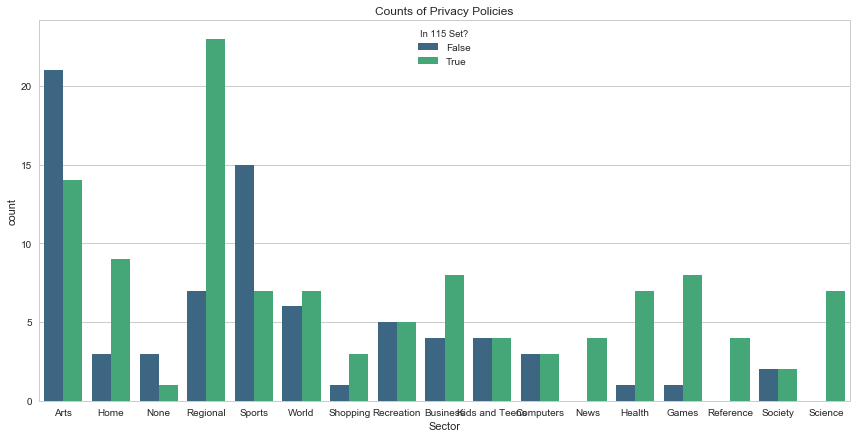

In [17]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
sns.countplot(x='Sector',data=sites,hue='In 115 Set?',palette='viridis')
plt.tight_layout()
plt.title('Counts of Privacy Policies')

In [25]:
sites_115 = sites[sites['In 115 Set?']]
sites_115.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 191
Data columns (total 12 columns):
Policy UID                  116 non-null int64
Site UID                    116 non-null int64
Site URL                    116 non-null object
Site Human-Readable Name    116 non-null object
Site Check Date             116 non-null datetime64[ns]
In 115 Set?                 116 non-null bool
Comments                    116 non-null object
Sector                      116 non-null object
Policy URL                  116 non-null object
Policy collection date      116 non-null datetime64[ns]
Policy last updated date    83 non-null datetime64[ns]
policy_text                 115 non-null object
dtypes: bool(1), datetime64[ns](3), int64(2), object(6)
memory usage: 11.0+ KB


In [28]:
sites_115['policy_length'] = sites_115['policy_text'].apply(lambda s: len(s) if s is not None else 0)

0      21501
1      12671
2      23548
3      14704
15     27005
24     31491
25      5787
26     26608
28     24123
30     14483
31     14570
32     17998
33     18823
34     18760
35     78598
41      8323
42     19747
43     18751
51     18512
52      9306
53     15561
55     12531
61     19328
62     18823
63     10162
64     15939
65      5527
66     21367
67     17198
68     10865
       ...  
153     2163
154     6193
155    14626
156    19673
157    43661
158    14303
159     1838
160     5537
161     9183
162    24671
163     6786
164     4643
165    22405
167    22341
168     9316
169     9110
175    13212
176    39318
177    10372
178    10805
179    26372
180    14599
181    15314
182    12316
184    12565
185    38908
186    20477
187     4339
189    19958
191    46581
Name: policy_text, Length: 116, dtype: int64

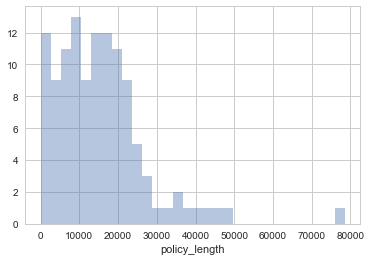

In [33]:
sns.distplot(sites_115['policy_length'],kde=False,bins=30)

# Site Annotations

## Originals

In [79]:
#Grab all annotations from annotations table
sql = """
SELECT * FROM annotations;
"""
annotations = pd.read_sql_query(sql,con)
annotations.head()

,Policy UID,annotation_id,batch_id,annotator_id,segment_id,category_name,attributes_value_pairs,date,policy_url
0,1017,20137,test_category_labeling_highlight_fordham_aaaaa,121,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",NaT,http://www.sci-news.com/privacy-policy.html
1,1017,20324,test_category_labeling_highlight_fordham_aaaaa,121,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",NaT,http://www.sci-news.com/privacy-policy.html
2,1017,20325,test_category_labeling_highlight_fordham_aaaaa,121,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",NaT,http://www.sci-news.com/privacy-policy.html
3,1017,20326,test_category_labeling_highlight_fordham_aaaaa,121,2,Data Retention,"{""Personal Information Type"": {""selectedText"":...",NaT,http://www.sci-news.com/privacy-policy.html
4,1017,20327,test_category_labeling_highlight_fordham_aaaaa,121,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele...",NaT,http://www.sci-news.com/privacy-policy.html


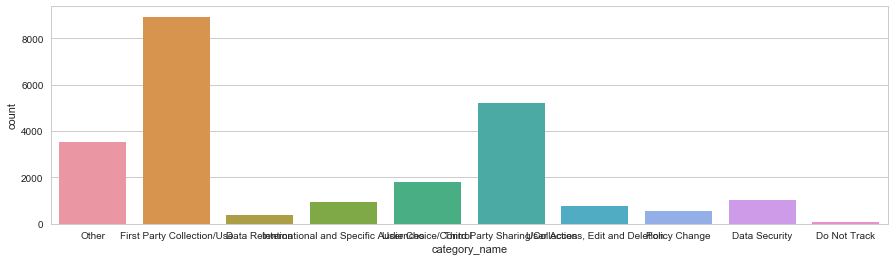

In [45]:
#Plot of counts of all categories of annotations across all sites
plt.figure(figsize=(15,4))
sns.countplot(annotations['category_name'])

First party collection and third party sharing get most share. Do not track is rare. Policy change is rare.

In [78]:
#All annotations crossed with site categories
pids = sites[['Policy UID','Sector']].set_index('Policy UID',drop=True).to_dict()
pids = pids['Sector']
annotations['sectors'] = annotations['Policy UID'].map(pids)

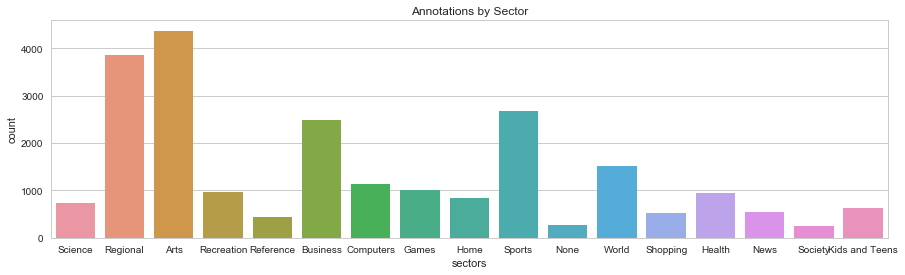

In [87]:
#Plot it
plt.figure(figsize=(15,4))
sns.countplot(annotations['sectors'])
plt.title('Annotations by Sector')

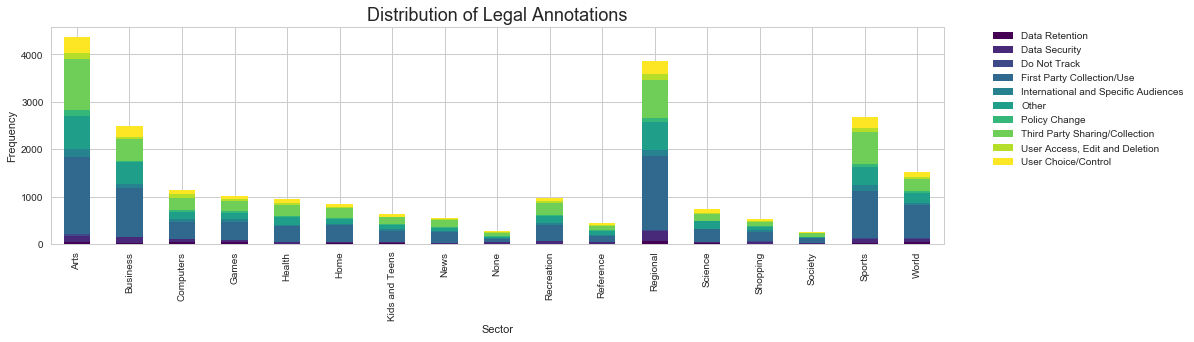

In [97]:
#How are policies distributed across sectors and category types?
ax = annotations.groupby(['sectors','category_name']).count()['annotation_id'].unstack(level=-1).plot.bar(stacked=True,
                figsize=(16,4),colormap='viridis')
ax.set_ylabel('Frequency')
ax.set_xlabel('Sector')
ax.set_title('Distribution of Legal Annotations',fontdict={'fontsize':18})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

What do policy lengths look like? Is this a distinguishing feature at the document level or by sector?

In [105]:
ann_counts = annotations.groupby('Policy UID').count()['annotation_id'].to_dict()
sites_115['n_annotations'] = sites_115['Policy UID'].map(ann_counts)

/Users/peterostendorp/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


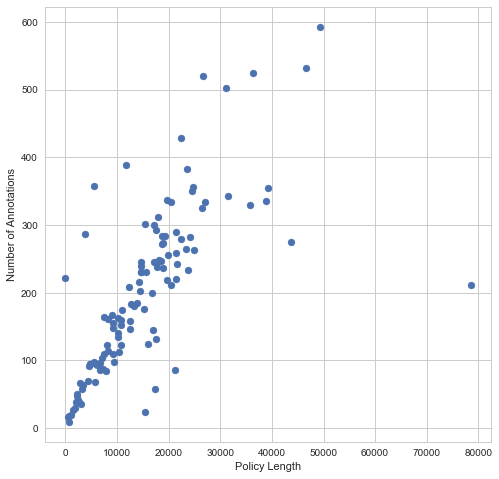

In [107]:
plt.figure(figsize=(8,8))
plt.scatter(sites_115['policy_length'],sites_115['n_annotations'])
plt.xlabel('Policy Length')
plt.ylabel('Number of Annotations')

Generally, the larger the policy, the more legal annotations. There are a few outliers. Does this help us?

## What's in the text_selections table?

In [109]:
sql = """
SELECT "attribute","value" FROM text_selections_new;
"""
txt_selections = pd.read_sql_query(sql,con)

In [110]:
txt_selections.head()

,attribute,value
0,Other Type,Introductory/Generic
1,Collection Mode,Explicit
2,Choice Scope,not-selected
3,Action First-Party,Unspecified
4,Personal Information Type,Unspecified


In [111]:
txt_selections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146865 entries, 0 to 146864
Data columns (total 2 columns):
attribute    146865 non-null object
value        146865 non-null object
dtypes: object(2)
memory usage: 2.2+ MB


In [113]:
txt_selections['attribute'].unique()

array(['Other Type', 'Collection Mode', 'Choice Scope',
       'Action First-Party', 'Personal Information Type', 'Choice Type',
       'Identifiability', 'Does/Does Not', 'User Type', 'Purpose',
       'Retention Period', 'Retention Purpose', 'Audience Type',
       'Third Party Entity', 'Action Third Party', 'Access Type',
       'Access Scope', 'Change Type', 'User Choice', 'Notification Type',
       'Security Measure', 'Do Not Track policy'], dtype=object)

In [114]:
txt_selections['value'].unique()

array(['Introductory/Generic', 'Explicit', 'not-selected', 'Unspecified',
       'Does', 'Basic service/feature', 'Contact', 'Other',
       'User online activities', 'Location', 'Children',
       'Privacy contact information', 'Cookies and tracking elements',
       'Browser/device privacy controls', 'Analytics/Research',
       'Practice not covered', 'Unnamed third party', 'Both',
       'Generic personal information', 'Does Not', 'Receive/Shared with',
       'Dont use service/feature', 'First party collection',
       'First party use', 'Profile data', 'Collect on website',
       'Track on first party website/app', 'Delete account (full)',
       'General notice in privacy policy', 'Collection', 'Opt-in',
       'Implicit', 'Third party sharing/collection',
       'Privacy relevant change', 'Opt-out', 'Personal notice',
       'Opt-out via contacting company', 'User with account',
       'Demographic', 'Personalization/Customization', 'User profile',
       'Financial', 'Receive

## Not so pretty annotations

In [100]:
cols = ['annotation_id','batch_id','annotator_id','policy_id','segment_id','category_name','attribute-values',
        'policy_url','date']
atl = pd.read_csv('./annotations/20_theatlantic.com.csv',header=None,names=cols)
nyt = pd.read_csv('./annotations/26_nytimes.com.csv',header=None,names=cols)
amz = pd.read_csv('./annotations/105_amazon.com.csv',header=None,names=cols)

In [109]:
fr = [atl,nyt,amz]
names = 'Atlantic.com NYTimes.com Amazon.com'.split()
df = pd.concat(fr,keys = names,names=['Site'])
df = df.reset_index(level=0,)

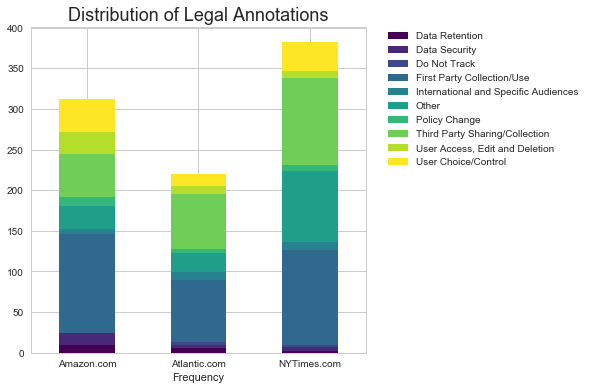

In [144]:
ax = df.groupby(by=['Site','category_name']).count()['annotation_id'].unstack(level=-1).plot.bar(stacked=True,
                figsize=(6,6),colormap='viridis')
ax.set_xlabel('Frequency')
ax.set_xticklabels(labels=['Amazon.com','Atlantic.com','NYTimes.com'],rotation='horizontal')
ax.set_title('Distribution of Legal Annotations',fontdict={'fontsize':18})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.savefig('./legalannotations_bar.png')

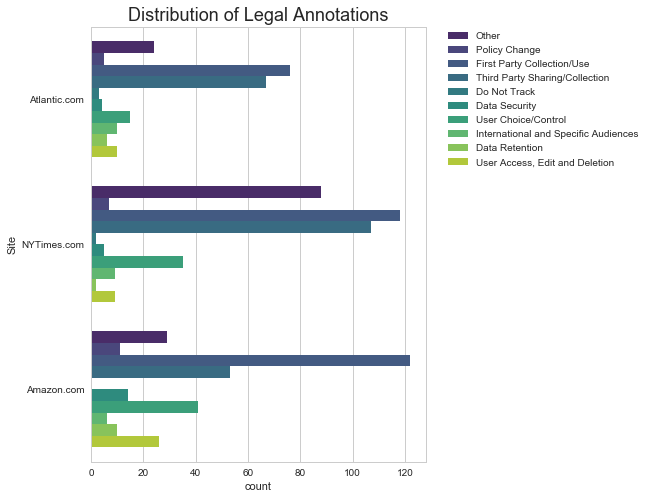

In [126]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,8))
sns.countplot(y='Site',data=df,hue='category_name',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.title('Distribution of Legal Annotations',fontdict={'fontsize':18})
plt.savefig('./annotation_distribution.png')